In [32]:
import numpy as np
import scipy as sp
import os 
import sys
import importlib
import copy
import meal_detection_utils as mdu
import result_utils as resu

import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
util_path = 'C:/ASM/Dropbox/Developments/Jupyter/Eating/myutils' if 'C:' in os.getcwd() else './myutils'
sys.path.append(util_path)
import my_file_utils as mfileu
import my_data_process_utils as mdpu

In [34]:
bites_proba_rf = mfileu.read_file('generated_for_result/bites', 'lab_bites_proba_rf.pkl')
bites_proba_our = mfileu.read_file('generated_for_result/bites', 'lab_bites_proba_our.pkl')
bites_pct_rf = mfileu.read_file('generated_for_result/bites', 'lab_bites_pct_offline_rf.pkl')
bites_pct_our = mfileu.read_file('generated_for_result/bites', 'lab_bites_pct_offline_our.pkl')

In [35]:
annots = mfileu.read_file('data', 'lab_annots_steven_right.pkl')
episodes = mfileu.read_file('data', 'lab_episodes_steven_right.pkl')
print("Lab episode count: ", len(episodes))

Lab episode count:  32


In [36]:
gt_bite_count_total = 1332
def get_bite_count_sess(clusters, cluster_cover):
    pos, neg = 0, 0    
    for i in range(len(clusters)):
        if cluster_cover[i] == 0:
            neg += clusters[i, 2]
        else:
            pos += clusters[i, 2]
    
    return pos, neg

In [ ]:
def get_results_exclude_subj(bites, percentile, exclude_subj, minDuration=0, minCount=3,  mergeDistance=5*60*16):    
    gts, acovs, clcovs = [], [], []
    pos_bite_detected, neg_bite_detected = 0, 0
    
    for subj in range(len(annots)):
        if subj == exclude_subj:
            continue
        
        for sess in range(len(annots[subj])):
            cond = (episodes[:,0]==subj) & (episodes[:,1]==sess)
            a = episodes[cond, 2:]
            
            b = bites[(subj, sess, percentile)]
            
            clusters1 = mdu.cluster_bites_by_minute(b)
            clusters2 = mdu.filter_clusters(clusters1, minDuration, minCount)            
            clusters = mdu.merge_clusters(clusters2, mergeDistance)
            #print(len(bites), len(clusters1), len(clusters2), len(clusters))
            
            gt, ac, clc = resu.get_meal_detection_results_lab(a, clusters=clusters)
            assert len(gt) == len(ac)
            
            ########### Bite Count            
            pb, nb = get_bite_count_sess(clusters, clc)            
            pos_bite_detected += pb            
            neg_bite_detected += nb
            
            #############
                        
            gt = mdpu.add_subj_sess_to_array(gt, subj, sess, at_begin=False)
            ac = mdpu.add_subj_sess_to_array(ac, subj, sess, at_begin=False)
            clc = mdpu.add_subj_sess_to_array(clc, subj, sess, at_begin=False)

            gts = gt if len(gts)==0 else np.concatenate((gts, gt))
            acovs = ac if len(acovs)==0 else np.concatenate((acovs, ac))
            clcovs = clc if len(clcovs)==0 else np.concatenate((clcovs, clc))
            
            
            
    res = resu.get_metric_results_lab(gts, acovs, clcovs)
    res["pos_bite_detected"] = pos_bite_detected    
    res["neg_bite_detected"] = neg_bite_detected
    
    return res 

In [37]:
def get_results(bites, percentile, minDuration=0, minCount=3,  mergeDistance=5*60*16):    
    gts, acovs, clcovs = [], [], []
    pos_bite_detected, neg_bite_detected = 0, 0
    
    for subj in range(len(annots)):
        for sess in range(len(annots[subj])):
            cond = (episodes[:,0]==subj) & (episodes[:,1]==sess)
            a = episodes[cond, 2:]
            
            b = bites[(subj, sess, percentile)]
            
            clusters1 = mdu.cluster_bites_by_minute(b)
            clusters2 = mdu.filter_clusters(clusters1, minDuration, minCount)            
            clusters = mdu.merge_clusters(clusters2, mergeDistance)
            #print(len(bites), len(clusters1), len(clusters2), len(clusters))
            
            gt, ac, clc = resu.get_meal_detection_results_lab(a, clusters=clusters)
            assert len(gt) == len(ac)
            
            ########### Bite Count            
            pb, nb = get_bite_count_sess(clusters, clc)            
            pos_bite_detected += pb            
            neg_bite_detected += nb
            
            #############
                        
            gt = mdpu.add_subj_sess_to_array(gt, subj, sess, at_begin=False)
            ac = mdpu.add_subj_sess_to_array(ac, subj, sess, at_begin=False)
            clc = mdpu.add_subj_sess_to_array(clc, subj, sess, at_begin=False)

            gts = gt if len(gts)==0 else np.concatenate((gts, gt))
            acovs = ac if len(acovs)==0 else np.concatenate((acovs, ac))
            clcovs = clc if len(clcovs)==0 else np.concatenate((clcovs, clc))
            
            
            
    res = resu.get_metric_results_lab(gts, acovs, clcovs)
    res["pos_bite_detected"] = pos_bite_detected    
    res["neg_bite_detected"] = neg_bite_detected
    
    return res 

In [38]:
#######################################################
########## Precision,  Recall, F1-Score, Start/End Errors (For percentile)

In [39]:
importlib.reload(mdu)
res = []
for p in range(9900,10000, 2):
    percentile = p/100    
    r = get_results(bites_pct_our, percentile)
    res.append([percentile, r["precision"], r["recall"], r["f1"], r["start_error"], r["end_error"], r["pos_bite_detected"], r["neg_bite_detected"]])
    #print(percentile, res["precision"], res["recall"], res["f1"], res["start_error"], res["end_error"], res["pos_bite_detected"], res["neg_bite_detected"])

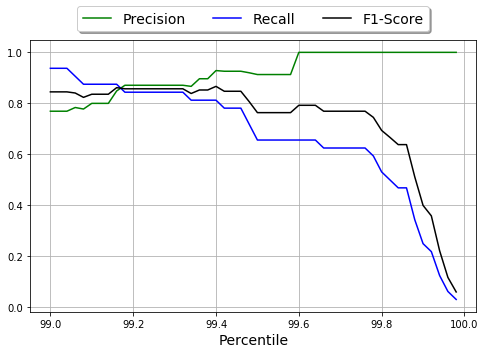

In [40]:
r = np.array(res)

fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)  

ax.plot(r[:,0], r[:,1], label='Precision', color='green')
ax.plot(r[:,0], r[:,2], label='Recall', color='blue')
ax.plot(r[:,0], r[:,3], label='F1-Score', color='black')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=True, fontsize=14)

plt.xlabel("Percentile", fontsize=14)        
#plt.ylabel("", fontsize=14)            
plt.grid(True)
plt.show()  

In [ ]:
#######################################################
########## Precision,  Recall, F1-Score, Start/End Errors (For proba)

In [ ]:
importlib.reload(mmdu)
res_rf = []
res_our = []
for p in range(10, 95, 5):
    proba = p/100
    res = get_results(all_bf_proba_rf[proba]["bite"]["list"])
    res_rf.append([proba, res["precision"], res["recall"], res["f1"], res["start_error"], res["end_error"], res["pos_bite_detected"], res["neg_bite_detected"]])
    #print(proba, res["precision"], res["recall"], res["f1"], res["start_error"], res["end_error"], res["pos_bite_detected"], res["neg_bite_detected"])
    
    res = get_results(all_bf_proba_our[proba]["bite"]["list"])
    res_our.append([proba, res["precision"], res["recall"], res["f1"], res["start_error"], res["end_error"], res["pos_bite_detected"], res["neg_bite_detected"]])
    #print(proba, res["precision"], res["recall"], res["f1"], res["start_error"], res["end_error"], res["pos_bite_detected"], res["neg_bite_detected"])

In [ ]:
res_rf, res_our = np.array(res_rf), np.array(res_our)

fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)  

r = res_rf
ax.plot(r[:,0], r[:,1], label='Precision (RF)', color='green', linestyle='--')
ax.plot(r[:,0], r[:,2], label='Recall (RF)', color='red', linestyle='--')
ax.plot(r[:,0], r[:,3], label='F1-Score (RF)', color='black', linestyle='--')

r = res_our
ax.plot(r[:,0], r[:,1], label='Precision (ConvBLSTM)', color='green')
ax.plot(r[:,0], r[:,2], label='Recall (ConvBLSTM)', color='red')
ax.plot(r[:,0], r[:,3], label='F1-Score (ConvBLSTM)', color='black')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=2, fancybox=True, shadow=True, fontsize=14)

plt.xlabel("Probablity Threshold", fontsize=14)        
#plt.ylabel("", fontsize=14)            
#plt.legend()
plt.grid(True)
plt.show()  


fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)  

r = res_rf
ax.plot(r[:,0], 100*r[:,-2]/gt_bite_count_total, label='BCR-TE (RF)', color='green', linestyle='--')
ax.plot(r[:,0], 100*r[:,-1]/gt_bite_count_total, label='BCR-FE (RF)', color='red', linestyle='--')
#ax.plot(r[:,0], 100*(r[:,-2]+r[:,-1])/gt_bite_count_total, label='BCR (RF)', color='blue', linestyle='--')

r = res_our
ax.plot(r[:,0], 100*r[:,-2]/gt_bite_count_total, label='BCR-TE (ConvBLSTM)', color='green')
ax.plot(r[:,0], 100*r[:,-1]/gt_bite_count_total, label='BCR-FE (ConvBLSTM)', color='red')
#ax.plot(r[:,0], 100*(r[:,-2]+r[:,-1])/gt_bite_count_total, label='BCR-T (ConvBLSTM)', color='blue')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=2, fancybox=True, shadow=True, fontsize=14)

plt.xlabel("Probablity Threshold", fontsize=14)        
plt.ylabel("Bite count rate (%)", fontsize=14)            
#plt.legend()
plt.grid(True)
plt.show()  

In [ ]:
res_rf, res_our = np.array(res_rf), np.array(res_our)

fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)  

r = res_rf
ax.plot(r[:,0], r[:,4]/60, label='Start Error (RF)', color='green', linestyle='--')
ax.plot(r[:,0], r[:,5]/60, label='End Error (RF)', color='blue', linestyle='--')


r = res_our
ax.plot(r[:,0], r[:,4]/60, label='Start Error (ConvBLSTM)', color='green')
ax.plot(r[:,0], r[:,5]/60, label='End Error (ConvBLSTM)', color='blue')


ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=2, fancybox=True, shadow=True, fontsize=14)

plt.xlabel("Probablity Threshold", fontsize=14)        
plt.ylabel("Error (Minute)", fontsize=14)            
#plt.legend()
plt.grid(True)
plt.show()

In [ ]:
importlib.reload(mmdu)
res_rf = []
res_our = []
for p in range(9800,10000, 2):
    percentile = p/100
    res = get_results(all_bf_percentile_rf[percentile]["bite_offline"]["list"])
    res_rf.append([percentile, res["precision"], res["recall"], res["f1"], res["start_error"], res["end_error"], res["pos_bite_detected"], res["neg_bite_detected"]])
    #print(percentile, res["precision"], res["recall"], res["f1"], res["start_error"], res["end_error"], res["pos_bite_detected"], res["neg_bite_detected"])
    
    res = get_results(all_bf_percentile_our[percentile]["bite_offline"]["list"])
    res_our.append([percentile, res["precision"], res["recall"], res["f1"], res["start_error"], res["end_error"], res["pos_bite_detected"], res["neg_bite_detected"]])
    #print(percentile, res["precision"], res["recall"], res["f1"], res["start_error"], res["end_error"], res["pos_bite_detected"], res["neg_bite_detected"])

In [ ]:
res_rf, res_our = np.array(res_rf), np.array(res_our)

fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)  

r = res_rf
ax.plot(r[:,0], r[:,1], label='Precision (RF)', color='green', linestyle='--')
ax.plot(r[:,0], r[:,2], label='Recall (RF)', color='red', linestyle='--')
ax.plot(r[:,0], r[:,3], label='F1-Score (RF)', color='black', linestyle='--')

r = res_our
ax.plot(r[:,0], r[:,1], label='Precision (ConvBLSTM)', color='green')
ax.plot(r[:,0], r[:,2], label='Recall (ConvBLSTM)', color='red')
ax.plot(r[:,0], r[:,3], label='F1-Score (ConvBLSTM)', color='black')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=2, fancybox=True, shadow=True, fontsize=14)

plt.xlabel("Percentile", fontsize=14)        
#plt.ylabel("", fontsize=14)            
#plt.legend()
plt.grid(True)
plt.show()  

fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)  

r = res_rf
ax.plot(r[:,0], 100*r[:,-2]/gt_bite_count_total, label='BCR-TE (RF)', color='green', linestyle='--')
ax.plot(r[:,0], 100*r[:,-1]/gt_bite_count_total, label='BCR-FE (RF)', color='red', linestyle='--')
#ax.plot(r[:,0], 100*(r[:,-2]+r[:,-1])/gt_bite_count_total, label='BCR (RF)', color='blue', linestyle='--')

r = res_our
ax.plot(r[:,0], 100*r[:,-2]/gt_bite_count_total, label='BCR-TE (ConvBLSTM)', color='green')
ax.plot(r[:,0], 100*r[:,-1]/gt_bite_count_total, label='BCR-FE (ConvBLSTM)', color='red')
#ax.plot(r[:,0], 100*(r[:,-2]+r[:,-1])/gt_bite_count_total, label='BCR-T (ConvBLSTM)', color='blue')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=2, fancybox=True, shadow=True, fontsize=14)

plt.xlabel("Percentile", fontsize=14)        
plt.ylabel("Bite count rate (%)", fontsize=14)            
#plt.legend()
plt.grid(True)
plt.show()  

In [ ]:
res_rf, res_our = np.array(res_rf), np.array(res_our)

fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)  

r = res_rf
ax.plot(r[:,0], r[:,4]/60, label='Start Error (RF)', color='green', linestyle='--')
ax.plot(r[:,0], r[:,5]/60, label='End Error (RF)', color='blue', linestyle='--')


r = res_our
ax.plot(r[:,0], r[:,4]/60, label='Start Error (ConvBLSTM)', color='green')
ax.plot(r[:,0], r[:,5]/60, label='End Error (ConvBLSTM)', color='blue')


ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=2, fancybox=True, shadow=True, fontsize=14)

plt.xlabel("Percentile", fontsize=14)        
plt.ylabel("Error (Minute)", fontsize=14)            
#plt.legend()
plt.grid(True)
plt.show()  